<a href="https://colab.research.google.com/github/sayanbanerjee32/NLP-with-fastai2.0/blob/main/fastai_on_20newsgroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#!pip install fastai --upgrade

In [16]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

In [17]:
def twenty_newsgroup_to_df(data_set = 'train'):
    newsgroups_train = fetch_20newsgroups(subset=data_set, 
                                          remove=('headers', 'footers',
                                                  'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame(newsgroups_train.target_names)
    targets.columns = ['title']

    train = pd.merge(df, targets, left_on='target', right_index=True)
    #out['date'] = pd.to_datetime('now')
    #out.to_csv('20_newsgroup.csv')
    return train


train_data_df = twenty_newsgroup_to_df('train')
test_data_df = twenty_newsgroup_to_df('test')

In [18]:
train_data_df.info(),test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11314 entries, 0 to 11302
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   target  11314 non-null  object
 2   title   11314 non-null  object
dtypes: object(3)
memory usage: 353.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7532 entries, 0 to 7519
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7532 non-null   object
 1   target  7532 non-null   object
 2   title   7532 non-null   object
dtypes: object(3)
memory usage: 235.4+ KB


(None, None)

In [19]:
from fastai.text.all import *

In [20]:
dls = TextDataLoaders.from_df(train_data_df, text_col='text', label_col='target')
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj archive - name : hockey - faq \n\n rec.sport.hockey answers to xxmaj frequently xxmaj asked xxmaj questions and other news : \n▁\n xxmaj contents : \n\n 0 . xxmaj new xxmaj info . \n 1 . xxup nhl \n 2 . xxup nhl xxmaj minor xxmaj leagues \n 3 . xxmaj college xxmaj hockey ( north xxmaj america ) \n 4 . xxmaj other leagues ( e.g. xxmaj europe , xxmaj canada xxmaj cup tournament ) \n 5 . xxmaj e - mail files \n 6 . xxup usenet xxmaj hockey xxmaj pool \n 7 . xxmaj up - coming xxmaj dates \n 8 . xxmaj answers to some frequently asked questions \n 9 . xxmaj miscellaneous \n▁\n▁ xxmaj send comments , suggestions and criticisms regarding this xxup faq list via xxunk \n mail to hamlet@u.washington.edu . \n▁\n▁ xxrep 74 - \n▁\n▁ 0 . xxmaj new xxmaj info",10
1,"xxbos xxmaj since electrical wiring questions do turn up from time to time on \n sci.electronics ( and the answers are n't always apparent , even to those skilled \n in electronics ) , i am xxunk the following xxup faq and posting a copy here . \n xxmaj i 've asked the writers to cross - post to sci.electronics in the future . \n\n\t▁ xxrep 3 - xxunk \n\n\n xxup x - news : xxunk news.answers : xxunk \n xxmaj newsgroups : misc.consumers.house , xxunk , news.answers , xxunk , xxunk \n xxmaj subject : xxmaj electrical xxmaj wiring xxup faq \n message - id : < xxunk > \n xxmaj from : xxunk ( chris xxmaj lewis ) \n xxmaj date : 4 xxmaj apr 93 xxunk xxup gmt \n reply - to : xxunk ( wiring xxup faq commentary reception ) \n followup - to : poster",12
2,"xxbos xxrep 10 - cut here xxrep 10 - part 03 / 03 \n xxup xxunk a \ - \ ( $ xxunk xxup xxunk < # xxup xxunk ( \n xxup xxunk u ) xxunk / xxup xxunk < xxunk # xxup xxunk xxup ad . "" / , ( , v1 # & w ; \n xxup xxunk xxunk : xxunk \ xxup xxunk % ! ] xxunk \n m / ' ' j - xxunk # \ xxunk # xxup xxunk ) \n xxup xxunk < xxunk . ; \ xxup xxunk = xxunk # xxunk \n xxup xxunk # xxup xxunk : al ' \n xxup xxunk : xxunk , xxunk ; \ ' xxunk \n xxup xxunk < hx - xxunk = xxunk / xxunk \n xxup mh = xxunk # xxup xxunk # xxunk - xxunk \n xxup xxunk / xxup xxunk : xxunk",2


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0831763744354248)

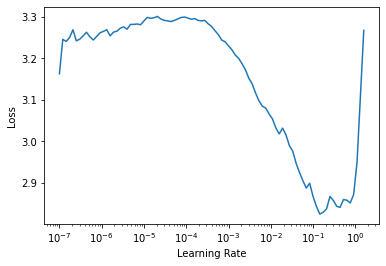

In [21]:
#dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
fscore = F1Score(average='weighted')
ls_fucn = CrossEntropyLossFlat()
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, 
                                loss_func = ls_fucn,
                                metrics=[accuracy,fscore])
#learn.fine_tune(2, 1e-2)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 0.001) # min / 10

epoch,train_loss,valid_loss,accuracy,f1_score,time


In [23]:
learn.fine_tune(5,0.001)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,nan,1.852960,0.437666,0.427115,01:10


KeyboardInterrupt: ignored